In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import h5py

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from pyhdf.SD import SD, SDC
import pyvista as pv
from scipy.sparse import coo_matrix
import cv2

from scipy import signal
from numpy.fft import fft2, ifft2, fft, ifft
from scipy.spatial.distance import cdist

[[2.93156562e+02 1.70765279e-12]
 [6.33575167e-12 2.89749696e+02]]
[[2.94857450e+02 8.31795285e-12]
 [8.22467883e-12 2.94857450e+02]]
[[ 2.95280172e+02 -1.37029779e-09]
 [-1.37005956e-09  2.95280172e+02]]
[[3.03399898e+02 4.43873006e-12]
 [4.59090481e-12 3.03399898e+02]]
[[ 2.92919928e+02 -1.18048967e-01]
 [-1.18048958e-01  2.92589402e+02]]


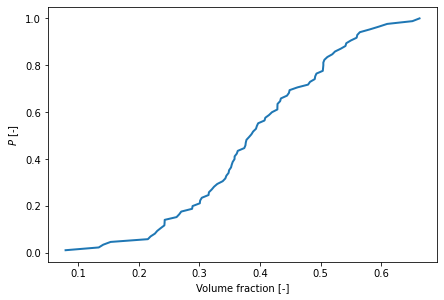

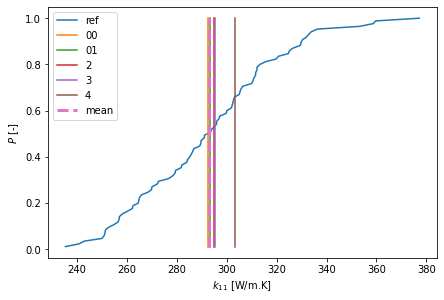

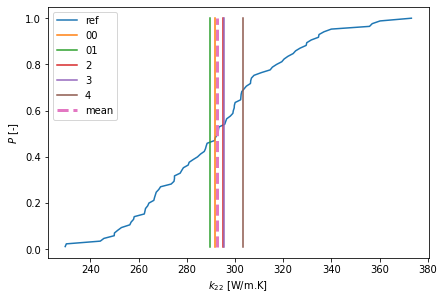

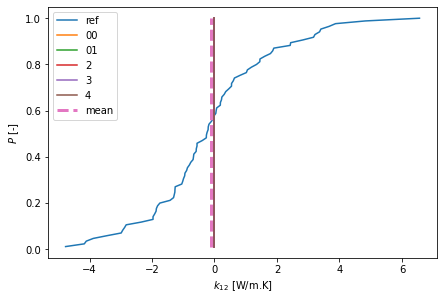

<ipython-input-27-940a868c385d>:130: RuntimeWarning: invalid value encountered in true_divide
  rel_err = np.abs(C_ref - C_approx) / np.abs(C_ref) * 100


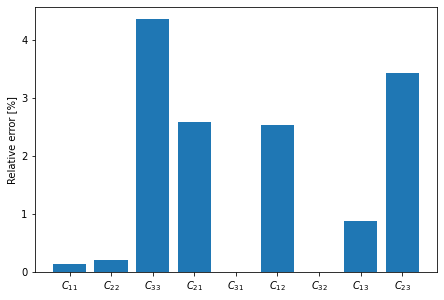

In [27]:
#%%
hf = h5py.File('data_2d/rve_response_sanath_1.h5', 'r')

n = 4
conductivity = [''] * n
temp_gradient_l1 = [''] * n
heat_flux_l1 = [''] * n
heat_flux_l2 = [''] * n
temp_fluctuation_l1 = [''] * n

for i in range(1, n + 1):
    conductivity[i - 1] = hf[f'images/dset{i}/thermal/conductivity'][:]
    temp_gradient_l1[i - 1] = hf[f'images/dset{i}/thermal/load1/strain'][:]
    heat_flux_l1[i - 1] = hf[f'images/dset{i}/thermal/load1/stress'][:]
    heat_flux_l2[i - 1] = hf[f'images/dset{i}/thermal/load2/stress'][:]
    temp_fluctuation_l1[i - 1] = hf[f'images/dset{i}/thermal/load1/uf'][:]
    print(conductivity[i - 1])
hf.close()

# conductivity[0]
# np.mean(heat_flux_l1[0],axis=1)
# np.mean(heat_flux_l2[0],axis=1)

hf = h5py.File('data_2d/selected_rve_results.h5', 'r')
conductivity_selected_rve = hf[f'images/stiffness'][:]
ms_selected_rve = hf[f'images/ms'][:]
hf.close()

hf = h5py.File('data_2d/rve_response_sanath_2.h5', 'r')
n = 85
conductivity_ref = [''] * n
ms_ref = [''] * n

for i in range(2, n + 2):
    conductivity_ref[i - 2] = hf[f'dset{i}/stiffness'][:]
    ms_ref[i - 2] = hf[f'dset{i}/ms'][:]
hf.close()

k_ref = np.sum(conductivity_ref, axis=0) / len(conductivity_ref)
print(k_ref)


vol_av = [np.sum(x) / x.size for x in ms_ref]
# plt.imshow(ms_ref[0].reshape(151,151))
plt.plot(*ecdf(vol_av), lw=2)
plt.ylabel('$P$ [-]')
plt.xlabel('Volume fraction [-]')
plt.tight_layout(pad=0.1)
# plt.savefig('vol_frac.png',dpi=600)
plt.show()

#%%
k11 = [x[0, 0] for x in conductivity_ref]
k22 = [x[1, 1] for x in conductivity_ref]
k12 = [x[0, 1] for x in conductivity_ref]
k21 = [x[1, 0] for x in conductivity_ref]

plt.plot(*ecdf(k11), label='ref')
plt.plot(*ecdf([conductivity_selected_rve[0, 0]] * len(k11)), label='00')
plt.plot(*ecdf([conductivity[0][0, 0]] * len(k11)), label='01')
plt.plot(*ecdf([conductivity[1][0, 0]] * len(k11)), label='2')
plt.plot(*ecdf([conductivity[2][0, 0]] * len(k11)), label='3')
plt.plot(*ecdf([conductivity[3][0, 0]] * len(k11)), label='4')
plt.plot(*ecdf([np.mean(k11)] * len(k11)), label='mean', lw=3, ls='--')
plt.ylabel('$P$ [-]')
plt.xlabel('$k_{11}$ [W/m.K]')
plt.legend()
plt.tight_layout(pad=0.1)
# plt.savefig('k11.png',dpi=600)
plt.show()

plt.plot(*ecdf(k22), label='ref')
plt.plot(*ecdf([conductivity_selected_rve[1, 1]] * len(k22)), label='00')
plt.plot(*ecdf([conductivity[0][1, 1]] * len(k22)), label='01')
plt.plot(*ecdf([conductivity[1][1, 1]] * len(k22)), label='2')
plt.plot(*ecdf([conductivity[2][1, 1]] * len(k22)), label='3')
plt.plot(*ecdf([conductivity[3][1, 1]] * len(k22)), label='4')
plt.plot(*ecdf([np.mean(k22)] * len(k22)), label='mean', lw=3, ls='--')
plt.ylabel('$P$ [-]')
plt.xlabel('$k_{22}$ [W/m.K]')
plt.legend()
plt.tight_layout(pad=0.1)
# plt.savefig('k22.png',dpi=600)
plt.show()

plt.plot(*ecdf(k12), label='ref')
plt.plot(*ecdf([conductivity_selected_rve[0, 1]] * len(k12)), label='00')
plt.plot(*ecdf([conductivity[0][0, 1]] * len(k12)), label='01')
plt.plot(*ecdf([conductivity[1][0, 1]] * len(k12)), label='2')
plt.plot(*ecdf([conductivity[2][0, 1]] * len(k12)), label='3')
plt.plot(*ecdf([conductivity[3][0, 1]] * len(k12)), label='4')
plt.plot(*ecdf([np.mean(k12)] * len(k12)), label='mean', lw=3, ls='--')
plt.ylabel('$P$ [-]')
plt.xlabel('$k_{12}$ [W/m.K]')
plt.legend()
plt.tight_layout(pad=0.1)
# plt.savefig('k12.png',dpi=600)
plt.show()
#%%
C_ref = []
C_ref.append(0.2009712484E+06)
C_ref.append(0.2003085180E+06)
C_ref.append(0.1435476658E+06)

C_ref.append(0.6315343376E+05)
C_ref.append(0)

C_ref.append(0.6313864690E+05)
C_ref.append(0)

C_ref.append(-0.1442707252E+05)
C_ref.append(-0.1411613899E+05)

C_approx = []
C_approx.append(0.2006790499E+06)
C_approx.append(0.2007297323E+06)
C_approx.append(0.1497855723E+06)

C_approx.append(0.6478809781E+05)
C_approx.append(0)

C_approx.append(0.6473344918E+05)
C_approx.append(0)

C_approx.append(-0.1430117968E+05)
C_approx.append(-0.1459888081E+05)

C_ref = np.asarray(C_ref)
C_approx = np.asarray(C_approx)
rel_err = np.abs(C_ref - C_approx) / np.abs(C_ref) * 100
# rel_err[4] = np.nan
# rel_err[6] = np.nan
plt.bar(['$C_{11}$', '$C_{22}$', '$C_{33}$', '$C_{21}$', '$C_{31}$', '$C_{12}$', '$C_{32}$', '$C_{13}$', '$C_{23}$'], rel_err)
plt.ylabel('Relative error [%]')
# plt.xlabel('$k_{12}$ [W/m.K]')
plt.tight_layout(pad=0.1)
# plt.savefig('elasticity.png',dpi=600)
plt.show()
#%%

# i = 0
# plt.imshow(temp_fluctuation_l1[i].reshape(151, 151))
# plt.show()
# plt.imshow(heat_flux_l1[i][0].reshape(151, 151).T)
# plt.show()
# plt.imshow(heat_flux_l1[i][1].reshape(151, 151).T)
# plt.show()

# plt.imshow(temp_gradient[i][0].reshape(151, 151).T)
# plt.show()
#
# plt.imshow(temp_gradient[i][1].reshape(151, 151).T)
# plt.show()

# plt.show(block=False)

# conductivity.shape
# Out[21]: (2, 2)
# temp_gradient.shape
# Out[22]: (2, 22801)
# heat_flux.shape
# Out[23]: (2, 22801)
# temp_fluctuation.shape
# Out[24]: (1, 22801)
# 151*151
# Out[25]: 22801

#%%
# 400 175
# conductivity_selected_rve = np.array([[2.92659875e+02, 2.70970915e-12],
#        [4.39629472e-12, 2.91946380e+02]])

# conductivity_matrix =np.array([[0.410664366623506, 0.000000000000002],
#   [-0.000000000000001,   0.402234424920195]])
# conductivity_homogenious = np.identity(2)
# conductivity_inclusions = conductivity_homogenious - conductivity_matrix

# print(400 * conductivity_matrix + 175 * conductivity_inclusions)

# 400*.6+175*.4
# 1/(1/400*.6+1/175*.4)

In [5]:
#%% read and visualise data
# 500 x 500 x 800 micrometers
micro_to_voxel_scaling_factor = 400 / 500
micro_to_voxel_scaling_factor_2d = 185 / 200
file = SD('/home/alameddin/src/0data/simkom_input_images/WS_2a.hdf', SDC.READ)
print(file.info())
print(file.datasets())
# 23: uint16 DFNT_UINT16 (23) 16-bit unsigned integer type

(1, 0)
{'Not specified': (('fakeDim0', 'fakeDim1', 'fakeDim2'), (986, 1012, 985), 23, 0)}


In [3]:
kt = file.select('Not specified')
print(kt.dimensions())
d3img = np.copy(kt[:, :, :])

rng = d3img < 30987
d3img[rng] = 0
d3img[~rng] = 1
d3img = d3img.astype(np.uint8)

xmax, ymax, zmax = d3img.shape
xmin, ymin, zmin = 0, 0, 0

xx, yy, zz = np.nonzero(d3img)
xmax = np.minimum(xx.max(), xmax)
xmin = np.maximum(xx.min(), xmin)

ymax = np.minimum(yy.max(), ymax)
ymin = np.maximum(yy.min(), ymin)

zmax = np.minimum(zz.max(), zmax)
zmin = np.maximum(zz.min(), zmin)

{'fakeDim0': 986, 'fakeDim1': 1012, 'fakeDim2': 985}


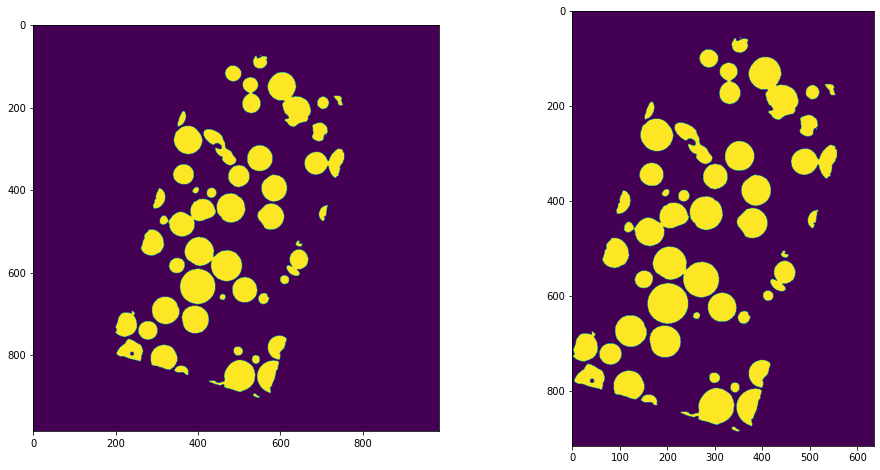

In [4]:
sub_imag = d3img[xmin:xmax, ymin:ymax, zmin:zmax]
fig,ax=plt.subplots(1,2,figsize=[16, 8])
ax[0].imshow(d3img[:, ymin+300, :])
ax[1].imshow(sub_imag[:, 300, :])

In [5]:
#%% fix orientation / rotate images
# https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html

# TODO: angle is already returned by cv2.minAreaRect()
#  OpenCV provides a function cv2.minAreaRect() for finding the minimum area rotated rectangle. This takes as input a 2D point set and returns a Box2D structure which contains the following details – (center(x, y), (width, height), angle of rotation). The syntax is given below.

def rotate(seg_slice, iterations=30):
    newimg = seg_slice * 255
    newimg_color = cv2.cvtColor(newimg, cv2.COLOR_GRAY2RGB)

    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(newimg, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # external contour when extracting many contours: np.argmax(h[:, :, 2] != -1)
    cnt = contours[0]

    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(newimg_color, [box], -1, (255, 0, 0), 3)
    
    
    fig,ax=plt.subplots(1,2,figsize=[16, 8])
    ax[0].imshow(newimg_color)
    # plt.savefig('3d_before_rotation.pdf', dpi=400)

    dd = box[1] - box[2]
    angle = np.rad2deg(np.arctan(dd[1] / dd[0])) if dd[0] != 0 else 0
    print(f'ang= {angle}')
    print(f'box= {box}')
    center = (box.mean(axis=0)[0], box.mean(axis=0)[1])
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    newimg_color = cv2.warpAffine(newimg_color, rot_mat, seg_slice.shape[1::-1], flags=cv2.INTER_LINEAR)

    ax[1].imshow(newimg_color)
    # plt.savefig('3d_after_rotation.pdf', dpi=400)
    return rot_mat

## Demo

ang= 17.904447506248204
box= [[194 747]
 [345 281]
 [735 407]
 [583 874]]
ang= 32.21820815475506
box= [[127 685]
 [428 208]
 [766 421]
 [464 898]]


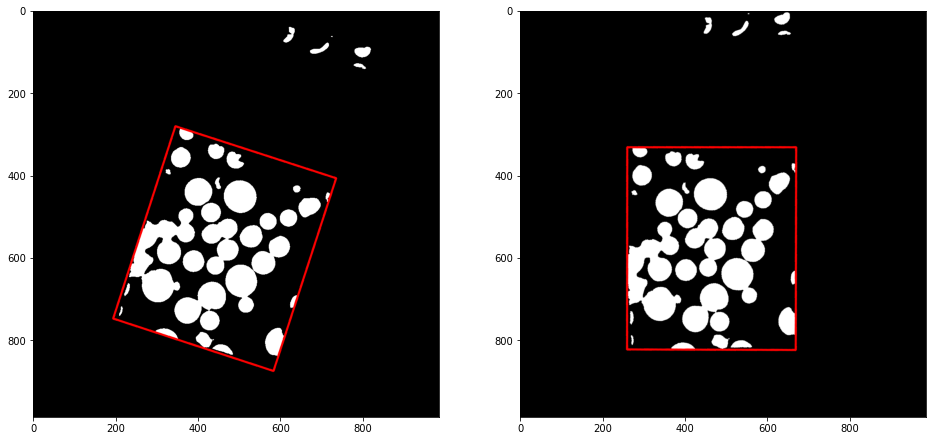

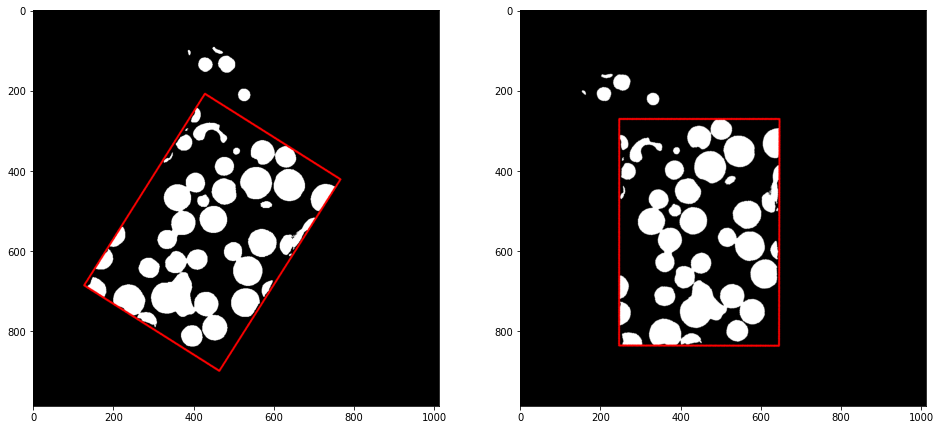

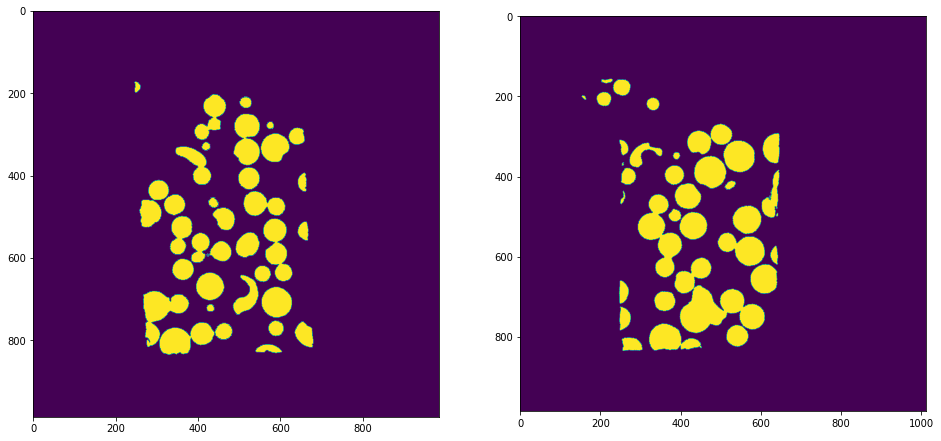

In [6]:
input_img = d3img[:, 350, :]
rot_mat = rotate(input_img, iterations=30)
for idx in range(d3img.shape[1]):
    if np.max(d3img[:, idx, :]) > 0:
        d3img[:, idx, :] = cv2.warpAffine(d3img[:, idx, :], rot_mat, input_img.shape[1::-1], flags=cv2.INTER_LINEAR)

input_img = d3img[:, :, 350]
rot_mat = rotate(d3img[:, :, 350], iterations=20)
for idx in range(d3img.shape[2]):
    if np.max(d3img[:, :, idx]) > 0:
        d3img[:, :, idx] = cv2.warpAffine(d3img[:, :, idx], rot_mat, input_img.shape[1::-1], flags=cv2.INTER_LINEAR)

#%% visualise and save cleaned data
fig,ax=plt.subplots(1,2,figsize=[16, 8])
ax[0].imshow(d3img[:, 350, :])
ax[1].imshow(d3img[:, :, 350])

# np.savez_compressed('/home/alameddin/src/0data/simkom_input_images/WS_2a.npz', d3img=d3img)

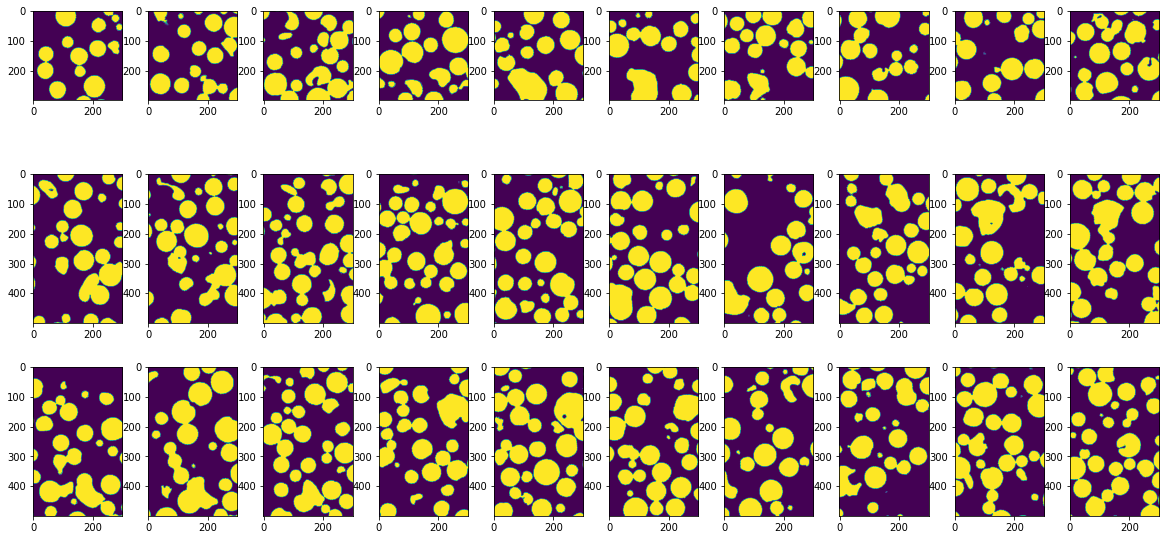

In [16]:
fig,ax=plt.subplots(3,10,figsize=[16, 8])
new_d3img = d3img[300:800, 300:600, 300:600]
for id,i in enumerate(range(0,300,30)):
    ax[0,id].imshow(new_d3img[i, :, :])
    ax[1,id].imshow(new_d3img[:, i, :])
    ax[2,id].imshow(new_d3img[:, :, i])
fig.tight_layout(pad=0.01)

## Volume average

In [2]:
data = np.load('/home/alameddin/src/0data/simkom_input_images/WS_2a.npz')
d3img = data['d3img']
print(f'global vol_av: {d3img.sum()/d3img.size = :.2f}')

global vol_av: d3img.sum()/d3img.size = 0.39


In [3]:
nlist = [3, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300]

outlistmean = []
outlistmedian = []
for n in nlist:
    volfilter = np.ones((n, n, n)) / n**3
    filteredimg = signal.fftconvolve(volfilter, d3img, mode='valid')
    print(np.mean(filteredimg))
    outlistmean.append(np.mean(filteredimg) * 100)
    outlistmedian.append(np.median(filteredimg) * 100)


0.38984647088304014
0.39802677190725055
0.40090298423940074
0.40052700578974365
0.40060707758005254
0.4006132852934321
0.40080683168583603


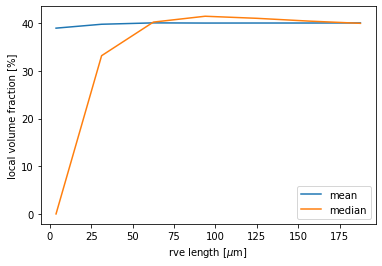

In [6]:
nlist = [x / micro_to_voxel_scaling_factor for x in nlist]
plt.plot(nlist, outlistmean, label='mean')
plt.plot(nlist, outlistmedian, label='median')
plt.xlabel('rve length [$\mu$m]')
plt.ylabel('local volume fraction [%]')
plt.legend()

## Statistics

<table align='center'>
<tr>
<td><img src='attachment/3d_ct_scan1.png' width='400' /></td>
<td><img src='attachment/3d_ct_scan2.png' width='400' /></td>
</tr>
</table>

42.5
105.0


Text(0.5, 1.0, 'ecdf')

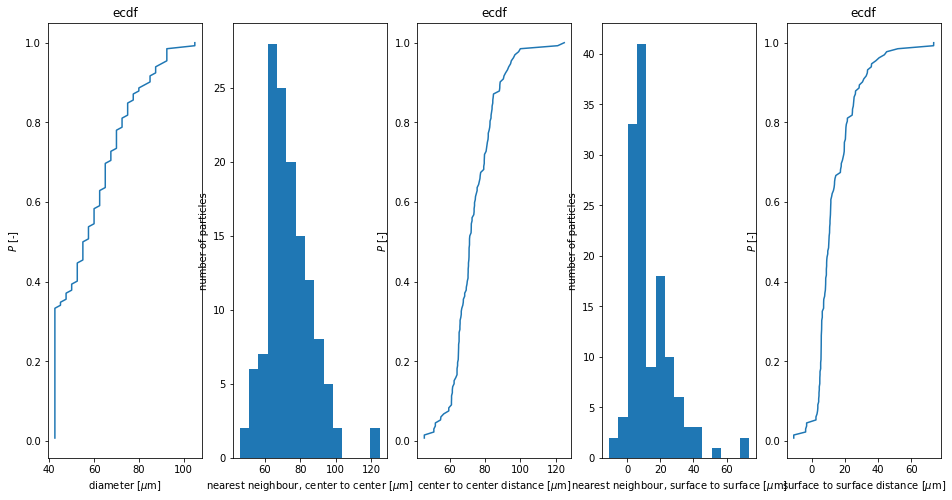

In [9]:
def ecdf(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n + 1) / n
    return (x, y)

f = np.load('/home/alameddin/src/0data/simkom_input_images/digital_3d.npz')
pos_and_r = f['pos_and_r']
f.close()

pos_and_r = pos_and_r / micro_to_voxel_scaling_factor
# diameter
diameter = 2 * pos_and_r[:, -1]
print(diameter.min())
print(diameter.max())

fig,ax=plt.subplots(1,5,figsize=[16, 8])

ax[0].plot(*ecdf(diameter))
ax[0].set_xlabel('diameter [$\mu$m]')
ax[0].set_ylabel('$P$ [-]')
ax[0].set_title('ecdf')
# plt.savefig('rve_particle_distribution_3d.pdf')

newp = pos_and_r[:, :3]
D = cdist(newp, newp)
np.fill_diagonal(D, np.nan)
# D[D < 40] = np.nan
D_side = D - pos_and_r[:, 3][:, None] - pos_and_r[:, 3][None, :]
d = np.nanmin(D, axis=0)
ax[1].hist(d, bins=15)
ax[1].set_xlabel('nearest neighbour, center to center [$\mu$m]')
ax[1].set_ylabel('number of particles')
# plt.savefig('rve_nearest_neighbour_distribution_3d.pdf', dpi=400)

ecdff = ecdf(np.asarray(d))
ax[2].plot(ecdff[0], ecdff[1])
ax[2].set_xlabel('center to center distance [$\mu$m]')
ax[2].set_ylabel('$P$ [-]')
ax[2].set_title('ecdf')
# ax[2].savefig('rve_nearest_neighbour_ecdf_3d.pdf', dpi=400)

d = np.nanmin(D_side, axis=0)
ax[3].hist(d, bins=15)
ax[3].set_xlabel('nearest neighbour, surface to surface [$\mu$m]')
ax[3].set_ylabel('number of particles')
# ax[3].savefig('rve_nearest_neighbour_distribution_surface_3d.pdf', dpi=400)

ecdff = ecdf(np.asarray(d))
ax[4].plot(ecdff[0], ecdff[1])
ax[4].set_xlabel('surface to surface distance [$\mu$m]')
ax[4].set_ylabel('$P$ [-]')
ax[4].set_title('ecdf')
# ax[4].savefig('rve_nearest_neighbour_ecdf_surface_3d.pdf', dpi=400)


## 2d image -> pickup random radius and calculate center to center ...

Text(0.5, 1.0, 'ecdf')

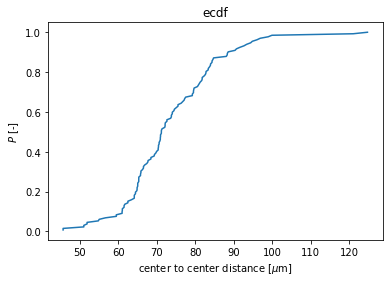

In [11]:
# plt.plot(*ecdf(diameter))
# plt.xlabel('diameter [$\mu$m]')
# plt.title('ecdf')
# plt.ylabel('$P$ [-]')


newp = pos_and_r[:, :3]
D = cdist(newp, newp)
np.fill_diagonal(D, np.nan)
# D[D < 40] = np.nan
# D = D - pos_and_r[:, 3][:, None] - pos_and_r[:, 3][None, :]
D[D < 0] = np.nan
d = np.nanmin(D, axis=0)
ecdff = ecdf(np.asarray(d))
plt.plot(ecdff[0], ecdff[1], label='3D')

plt.xlabel('center to center distance [$\mu$m]')
# plt.xlabel('surface to surface distance [$\mu$m]')
plt.ylabel('$P$ [-]')
plt.title('ecdf')

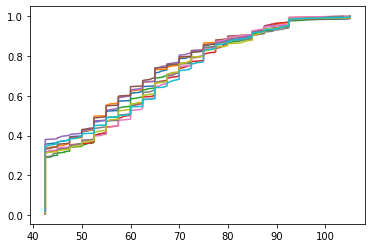

In [13]:
from scipy.interpolate import interp1d
from statsmodels.distributions.empirical_distribution import ECDF
ecdff = ECDF(diameter)
inv_cdf = interp1d(ecdff.y, ecdff.x, bounds_error=False, assume_sorted=True)
for i in range(10):
    p0 = np.random.uniform(0, 1, 342)
    r0 = inv_cdf(p0)
    ecdff = ECDF(r0)
    plt.plot(ecdff.x, ecdff.y)

No handles with labels found to put in legend.


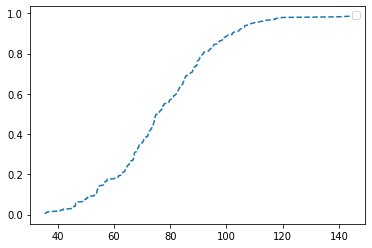

In [17]:
particles = np.load('/home/alameddin/src/0data/simkom_input_images/2d_particles.npy')
particles = particles / micro_to_voxel_scaling_factor_2d
z_squared = r0**2 - particles[:, 2]**2
z_squared[z_squared < 0] = 0
z0list = np.sqrt(z_squared)

newparticles = np.hstack((particles[:, :2], z0list[:, None]))
# newparticles2 = np.hstack((particles[:, :2], z0list[:, None]))
# newp = np.vstack((newparticles, newparticles2))
newp = newparticles
D = cdist(newp, newp)
# D = D - r0[:, None] - r0[None, :]
np.fill_diagonal(D, np.nan)
D[D < 0] = np.nan
d = np.nanmin(D, axis=0)
ecdff = ecdf(np.asarray(d))
if i == 0:
    plt.plot(ecdff[0], ecdff[1], label='2D', ls='--')
else:
    plt.plot(ecdff[0], ecdff[1], label=None, ls='--')

plt.legend()
# plt.savefig('rve_nearest_neighbour_ecdf_center_2d_3d.pdf', dpi=400)
# plt.savefig('rve_nearest_neighbour_ecdf_surface_2d_3d.pdf', dpi=400)